In [1]:
# %load ../../style.py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit
sns.set(style='ticks', palette='Set2') 
sns.despine()

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['axes.titlesize'] = fontsize_labels
xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  


In [2]:
import re
from scipy.constants import c,h,eV, pi
hceV = h * c  /eV
find_number = lambda string: re.search("-?\\d+",string).group(0)

from smooth import savitzky_golay
import uncertainties as uc
import uncertainties.unumpy as un

plt.close("all")
show_fig = True
save_fig = False # see below
if not save_fig:
        rcParams['figure.figsize'] = (13, 8)  # in inches; width corresponds to \textwidth in latex document (golden ratio)
        fig_dir = "../figures/"
        npy_dir = "./npy/"
        
xlim_global = (420, 610)

In [3]:
def breit_wigner(x, x0, gamma, amplitude, offset):
    """
    Breit-Wigner or Cauchy distribution with location parameter x0 
    and scale parameter gamma = 0.5 * FWHM. Amplitude: 1 / (Pi * gamma). 
    No mean, variance or higher moments exist.
    """
    return amplitude / ((pi*gamma) * (1 + ((x - x0) / gamma)**2)) + offset
    

In [25]:
def bw_fit(x, y, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(breit_wigner, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = breit_wigner(x_fit, *coeff)
    else:
        fit_peak = breit_wigner(x_fit, *p0)
        c = p0
    
    return x_fit, fit_peak, c

In [38]:
def print_c(c):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max 4 error digits
    as floats with max 3 error digits
    as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < 4): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


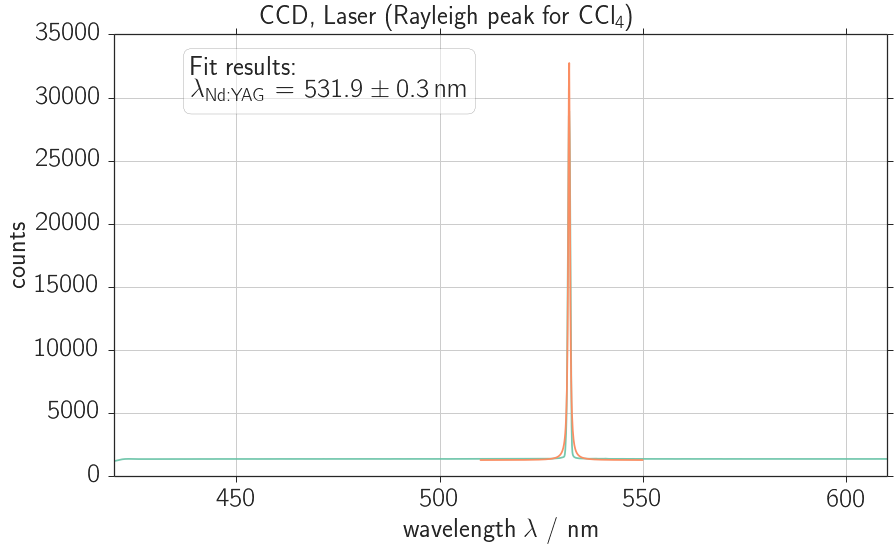

In [51]:
filename = "ccd_laser_ccl4_00"
# Get integration time and number of measurements
f = open("data/" + filename + ".txt", encoding='cp1252')
lines = f.readlines()
f.close()
t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from

# Data
x = np.load("npy/"+filename+"_lamb.npy")
y = np.load("npy/"+filename+"_count.npy")
y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))

# Fitting
# p = [x0, gamma, amplitude, offset]
###### PEAK 1 #################
# Define range to be fitted
x_range = [510, 550]   # lower and upper bound
p0 = np.array([531, 0.4, 27000, 1420])
x_fit1, fit_peak1, c1 = bw_fit(x, y, y_e, x_range, p0, fit=True)


# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD, Laser (Rayleigh peak for CCl$_4$)')
ax.plot(x, y, "-", alpha = 0.9)
ax.plot(x_fit1, fit_peak1, "-", label='Nd:YAG paek at 532 nm')
#ax.set_ylim(0,10000)
ax.set_xlim(xlim_global)
#ax.set_xlim(565, 585)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("counts")
ax.grid(True)
#ax.legend(loc='best')

# Get the parameters ofthe linear fit to be presented in a textbox
peak_str = print_c(uc.ufloat(c1[0].n, c1[1].n))
textstr = "Fit results:\n \
        \\begin{eqnarray*} \
        \\ \lambda_\mathrm{Nd:YAG} &=& %s \,\mathrm{nm} \\\\ \
        \end{eqnarray*}"%(peak_str)
ax1 = plt.gca()
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.1, 0.95, textstr, transform=ax1.transAxes, va='top', bbox=props)


plt.show()

In [40]:
c1

(531.8530783459971+/-1.182917078615784e-05,
 0.25406507163468234+/-1.4742323808308653e-05,
 25410.451696578657+/-1.0354299467767465,
 1253.271457681994+/-0.05615185281013084)